# NDBC Spectral Wave Summary Data For Buoy 46224

<img src="http://www.ndbc.noaa.gov/images/stations/scripps.jpg" style="float: right;display:block;margin:auto;width:15%;"/>

In the following blog entery the last 45 days of [Spectral Wave Summary Data](http://www.ndbc.noaa.gov/data/realtime2/46244.spec) for buoy 46224 from the National Buoy Data Center (NDBC) will be explored.  The data will then be presented as a series of visualizations, produced with matplotlib and seaborn.

The NDBC provides data files for each of its stations, the following are the data files for buoy 46224:

|File             |Description                  
|-----------------|----------------------------
|46244.txt        | Real time standard meteorological data
|46244.data_spec  | Raw Spectral Wave Data     
|46244.spec       | Spectral Wave Summary Data
|46244.swdir      | Spectral Wave Data (alpha1)
|46244.swdir2     | Spectral Wave Data (alpha2)
|46244.swr1       | Spectral Wave Data (r1)
|46244.swr2       | Spectral Wave Data (r2)

To get started the data will be loaded into a data frame and the first few lines of data will be displayed.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def read_station(station_id, data_file):
    """Read data from NDBC to a pandas data frame.
    
    Read data from the National Data Buoy Center (NDBC) given the station number
    and data file extension.  Only the file extenstions listed under the station_id 
    argument have been tested.
    
    Args:
        station_id: Five digit NDBC station id number.
        data_file: Must be on of the following strings 'txt', 'data_spec', 'spec', 
            'swdir','swdir2', 'swr1', or 'swr2'.
    
    Returns:
        A pandas data frame.
    """
    # Contruct url of data file.
    base = 'http://www.ndbc.noaa.gov/data/realtime2/'
    url = base + station_id + '.' + data_file

    # Set up keyword arguments for pd.read_csv().
    kwargs = {
        'index_col': 0,
        'delim_whitespace': True,
        'parse_dates': {'Date': [0, 1, 2, 3, 4]},
        'na_values': ['MM', -99, 999.0], }

    # Set up custom keyword arguments based on file type and read data. 
    if data_file == 'txt' or 'spec': # Spectral Wave Summary Data
        kwargs['header'] = 0
        kwargs['skiprows'] = [1]

        df = pd.read_csv(url, **kwargs)
    else: # Spectral Wave Files
        kwargs['header'] = None
        kwargs['skiprows'] = [0]
        spec = int(data_file == 'data_spec')
        kwargs['usecols'] = [0, 1, 2, 3, 4] + list(range(5 + spec, 132 + spec, 2))

        df = pd.read_csv(url, **kwargs)

        # Hard coded frequency headings.
        spec_heading = np.array([25 + 5 * num for num in range(0, 15)] + [101] +
                                [110 + 10 * num for num in range(0, 48)]
                               ) / 1000
        df.columns = spec_heading

    # Convert index to a pandas datetime object.
    df.index = pd.to_datetime(df.index, format="%Y %m %d %H %M")

    return df

# Read in raw data.
try:
    df_raw = pd.read_csv('spec_summary.csv', index_col='Date', date_parser=True)
except:
    df_raw = read_station('46244', 'spec')
    df_raw.to_csv('spec_summary.csv', float_format='%.3f') #Fix float round offs and save data.
    
df_raw.head(3)

,WVHT,SwH,SwP,WWH,WWP,APD,MWD
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,2.507759,1.535767,12.724288,1.879982,9.058770,7.858770,278.959596
std,0.862818,0.785199,2.145821,0.581015,1.161141,1.438275,25.630465
min,0.900000,0.400000,10.500000,0.600000,4.500000,4.300000,188.000000
25%,1.900000,1.000000,11.100000,1.500000,8.300000,6.725000,270.000000
50%,2.400000,1.400000,11.800000,1.800000,9.900000,7.800000,284.000000
75%,3.000000,1.900000,14.300000,2.200000,9.900000,8.900000,292.000000
max,6.800000,5.300000,20.000000,5.100000,9.900000,12.700000,342.000000


## Data Cleaning
The direction strings in 'SwD' (swell direction) and 'WWD' (wind wave direction) will be converted to degress from north.  This helps in calculating summary statistics for these columns and makes them easier to plot.

Also, feet are more comenly used for weather reporting so meters will be converted to feet.  

In [40]:
# List direction strings and thier corresponing degree measures.
compass = ['NNE', 'NE', 'ENE', 'E', 
           'ESE', 'SE', 'SSE', 'S', 
           'SSW', 'SW', 'WSW', 'W', 
           'WNW', 'NW', 'NNW', 'N']
compass_deg = np.linspace(22.5, 360, len(compass))

# Replace direction strings with degrees.
df = df_raw.replace(to_replace=compass, value=compass_deg)

# Convert wave heights to feet.
df.loc[:, ['WVHT', 'SwH', 'WWH']] = np.around(df_raw.loc[:, ['WVHT', 'SwH', 'WWH']]*3.28, decimals=1)
df.head(3)

,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,STEEPNESS,APD,MWD
Date,,,,,,,,,,
2017-05-05 22:21:00,8.5,3.6,12.5,7.5,7.7,315.0,292.5,AVERAGE,6.5,307
2017-05-05 21:51:00,8.5,4.6,11.1,7.2,7.7,292.5,270.0,AVERAGE,6.6,290
2017-05-05 21:21:00,7.9,3.6,11.8,6.9,9.9,292.5,292.5,AVERAGE,6.2,298


## Summerising the Spetral Wave data
Note the minimum values for 'SwP' (swell period) is 10.5 seconds and the maximum value for 'WWP' (wind wave period) is 9.9 seconds. The 0.6 second gap between the 'SwP' data and the 'WWP' data is interesting. It is possible that any waves with periods from 10 to 10.4 seconds are rounded down to 9.9 seconds.  This hypothesis is supported by the fact that the 50th and 75th percetiles for 'WWP' also report 9.9 seconds.

In [41]:
df.describe()

,WVHT,SwH,SwP,WWH,WWP,SwD,WWD,APD,MWD
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,8.225023,5.034986,12.724288,6.164141,9.058770,280.402893,275.888430,7.858770,278.959596
std,2.831896,2.575922,2.145821,1.907357,1.161141,19.572870,33.231233,1.438275,25.630465
min,3.000000,1.300000,10.500000,2.000000,4.500000,202.500000,180.000000,4.300000,188.000000
25%,6.200000,3.300000,11.100000,4.900000,8.300000,270.000000,270.000000,6.725000,270.000000
50%,7.900000,4.600000,11.800000,5.900000,9.900000,292.500000,270.000000,7.800000,284.000000
75%,9.800000,6.200000,14.300000,7.200000,9.900000,292.500000,292.500000,8.900000,292.000000
max,22.300000,17.400000,20.000000,16.700000,9.900000,337.500000,337.500000,12.700000,342.000000


## Correlation Heatmap, Plots, and Histograms

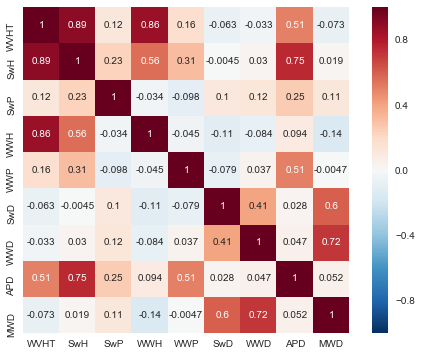

In [42]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8, 6)) 

# Graph correlation matrix.
sns.heatmap(corr, ax=ax, square=True, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

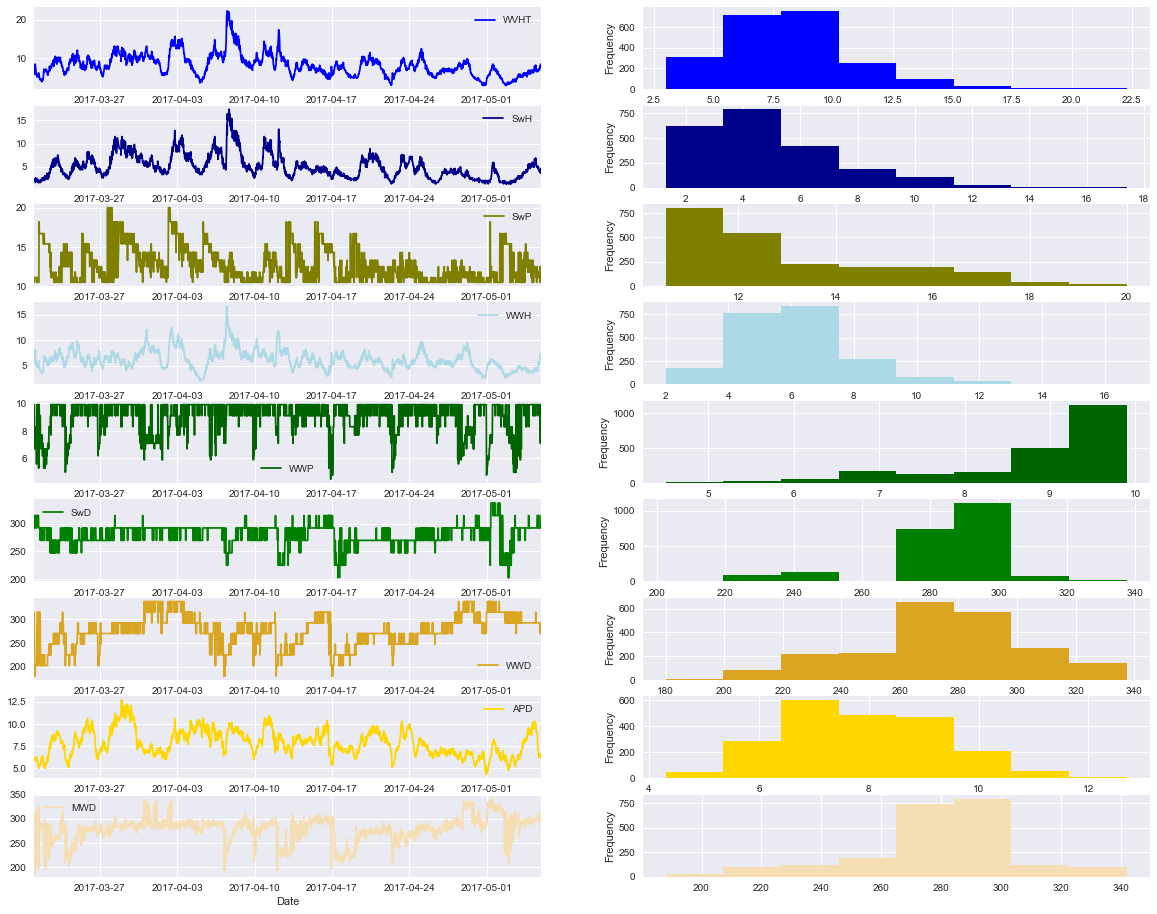

In [50]:
# Set up subplots and colors for plots.
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(20, 16))
colors = ['blue', 'darkblue', 'olive', 'lightblue', 'darkgreen', 'green', 'goldenrod', 'gold', 'wheat']

# Set up targets for each column in the data frame then plot them.
target = [axes[idx, 0] for idx in range(len(axes))]
df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9]].plot(subplots=True, ax=target, color=colors)
    
# Plot the histogram for each plot next to the regular plot.
col = 1
cols = [0, 1, 2, 3, 4, 5, 6, 8, 9]
for idx in range(len(axes)):
    df.iloc[:, cols[idx]].plot.hist(ax=axes[idx, col], bins=8, color=colors[idx])

TypeError: Illegal arguments to pcolormesh; see help(pcolormesh)

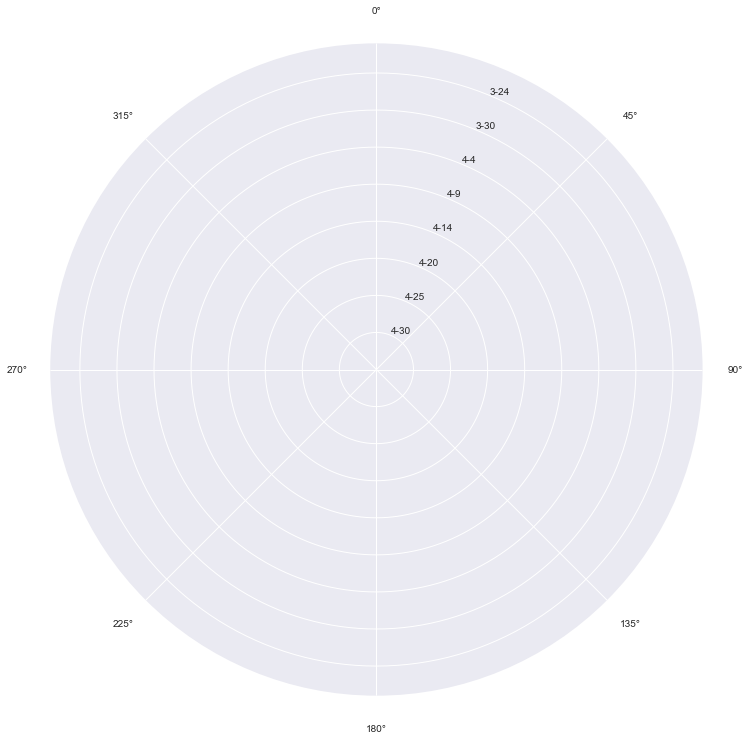

In [55]:
def lin_scale(array, sz_min, sz_max):
    """Scale a numpy array to span from sz_min to sz_max."""
    scale_diff = sz_max - sz_min
    lst_diff = max(array) - min(array)
    
    # Get the slope (m) and y-intercept (b) to scale the array.
    m = np.divide(scale_diff, lst_diff)
    b = np.divide(sz_min * max(array) - sz_max * min(array), lst_diff)
    
    return m * array + b

def polar_wave(df, height='SwH', period='SwP', direction='SwD', ax=None):
    """Plot of wave height, period and direction on polar axes."""
    # Set up polar projection to correspond to the compass rose.
    if ax == None:
        fig = plt.figure(figsize=(12,10))
        ax = plt.subplot(polar=True)
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    
    # Set up radius limits and create meaningful ytick (radius) labels.
    ax.set_rlim([0, len(df) + len(df)/100])
    tics = np.array(ax.get_yticks()).astype(int)
    dates = [df.index[tic] for tic in tics if tic < len(df)]
    tic_lables = [str(date.month) + '-' + str(date.day) for date in dates]
    ax.yaxis.set_ticklabels(tic_lables)

    # Set up scale for points sizes.
    pntsz_min = 5
    pntsz_max = 200
    scaled_heights = lin_scale(df[height], pntsz_min, pntsz_max)

    # Create plot and colorbar.
    sc = ax.pcolormesh(Y=range(len(df)), 
                    X=np.radians(df[direction]), 
#                     c=df[period], 
#                     s=scaled_heights,
#                     cmap='viridis_r',
                      )
#     sc = ax.scatter(y=range(len(df)), 
#                     x=np.radians(df[direction]), 
#                     c=df[period], 
#                     s=scaled_heights,
#                     cmap='viridis_r')
    cbar = plt.colorbar(sc);
    cbar.set_label('Period')

    # Create legend.
    label = str(df[height].max()) +'\''
    ax.scatter(x=[],y=[], 
               s=pntsz_min, 
               label=str(df[height].min()) + '\'')
    ax.scatter(x=[],y=[], 
               s=pntsz_max,
               label=str(df[height].max()) + '\'')
    plt.legend(title='Wave Heights', scatterpoints=1, fontsize=9, ncol=2, loc=4, frameon=True)
    return sc

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111, projection='polar')
polar_wave(df, ax=ax);
polar_wave(df, height='WWH', direction='WWD', period='WWP', ax=ax)